In [48]:
import item_recsys as ir
from importlib import reload
import pandas as pd
import numpy as np

In [31]:
movies_df = pd.read_parquet('imdb_movies.parquet')
movies_df

,title_id,poster_url,type,name,original_name,description,genre,date,rating_count,rating_value,keywords,featured_review,stars,directors,creators
0,tt0111161,https://m.media-amazon.com/images/M/MV5BNDE3OD...,Movie,Побег из Шоушенка,The Shawshank Redemption,"Over the course of several years, two convicts...",[Drama],1994-10-14,2755277.0,9.3,"[prison, based on the works of stephen king, e...",It is no wonder that the film has such a high ...,"[Tim Robbins, Morgan Freeman, Bob Gunton]",[Frank Darabont],"[Stephen King, Frank Darabont]"
1,tt0068646,https://m.media-amazon.com/images/M/MV5BM2MyNj...,Movie,Крестный отец,The Godfather,"Don Vito Corleone, head of a mafia family, dec...","[Crime, Drama]",1972-03-24,1917037.0,9.2,"[mafia, patriarch, crime family, organized cri...",I love this movie and all of the GF movies. I ...,"[Marlon Brando, Al Pacino, James Caan]",[Francis Ford Coppola],"[Mario Puzo, Francis Ford Coppola]"
2,tt0468569,https://m.media-amazon.com/images/M/MV5BMTMxNT...,Movie,Тёмный рыцарь,The Dark Knight,When the menace known as the Joker wreaks havo...,"[Action, Crime, Drama]",2008-08-14,2728169.0,9.0,"[dc comics, psychopath, moral dilemma, superhe...","If someone else acted as Joker, I would give t...","[Christian Bale, Heath Ledger, Aaron Eckhart]",[Christopher Nolan],"[Jonathan Nolan, Christopher Nolan, David S. G..."
3,tt0050083,https://m.media-amazon.com/images/M/MV5BMWU4N2...,Movie,12 разгневанных мужчин,12 Angry Men,The jury in a New York City murder trial is fr...,"[Crime, Drama]",1961-11-13,816234.0,9.0,"[jury, dialogue driven, courtroom, trial, jury...",&apos;12 Angry Men&apos; is an outstanding fil...,"[Henry Fonda, Lee J. Cobb, Martin Balsam]",[Sidney Lumet],[Reginald Rose]
4,tt0071562,https://m.media-amazon.com/images/M/MV5BMWMwMG...,Movie,Крестный отец 2,The Godfather Part II,The early life and career of Vito Corleone in ...,"[Crime, Drama]",1974-12-18,1305122.0,9.0,"[revenge, 1950s, corrupt politician, cuban rev...",The original Godfather is a brilliant work. It...,"[Al Pacino, Robert De Niro, Robert Duvall]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,tt0090670,https://m.media-amazon.com/images/M/MV5BMmMwOD...,Movie,В упор,At Close Range,"Reunited with his career criminal father, toug...","[Crime, Drama]",1986-04-18,16925.0,6.9,"[real life brothers playing brothers, criminal...",The look of the film says rural poverty. There...,"[Sean Penn, Christopher Walken, Mary Stuart Ma...",[James Foley],"[Elliott Lewitt, Nicholas Kazan]"
9794,tt0118954,https://m.media-amazon.com/images/M/MV5BMDVjZW...,Movie,Разбирая Гарри,Deconstructing Harry,Suffering from writer&apos;s block and eagerly...,[Comedy],1998-01-02,46450.0,7.3,"[lucifer morningstar character, death characte...",Just as I&apos;ve found a newfound appreciatio...,"[Woody Allen, Judy Davis, Julia Louis-Dreyfus]",[Woody Allen],[Woody Allen]
9795,tt0074695,https://m.media-amazon.com/images/M/MV5BNGQ1Yj...,Movie,Железный крест,Cross of Iron,German commander Hauptmann Stransky places a s...,"[Drama, War]",1977-02-10,27651.0,7.4,"[iron cross, german soldier, military decorati...",&quot;Cross of Iron&quot; was Sam Peckinpah&ap...,"[James Coburn, Maximilian Schell, James Mason]",[Sam Peckinpah],"[Julius J. Epstein, Walter Kelley, James Hamil..."
9796,tt0164334,https://m.media-amazon.com/images/M/MV5BOTVlY2...,Movie,И пришел паук,Along Came a Spider,When a senator&apos;s daughter under Secret Se...,"[Drama, Thriller]",2001-07-19,92240.0,6.4,"[kidnapping, ransom, based on novel, police of...","A terrific movie. Suspense, thrills and a plot...","[Morgan Freeman, Michael Wincott, Monica Potter]",[Lee Tamahori],"[James Patterson, Marc Moss]"


## Ideas
- отдельно строить матрицы схожестей для признаков фильма (какие режиссёры/актёры и т.д.)
и использовать в ансамле ещё и их
- попробуйте использовать description и featured_review для извлечения признаков
(например, tf-idf/w2v/openAI эмбеддинги)

In [24]:
import sentence_transformers as st
model_name = 'all-mpnet-base-v2'
model = st.SentenceTransformer(model_name)

In [35]:
featured_review_list: list[str] = movies_df['featured_review'].fillna('').to_list()

In [36]:
null_indices: list[int] = movies_df[movies_df['featured_review'].isnull()].index.tolist()

In [39]:
%%time
featured_review_embs = model.encode(featured_review_list, batch_size=1024)
featured_review_embs.shape

CPU times: user 51.9 s, sys: 114 ms, total: 52 s
Wall time: 40.9 s


(9798, 768)

In [44]:
similarities = st.util.dot_score(featured_review_embs, featured_review_embs).numpy()
similarities -= np.eye(len(similarities), dtype=similarities.dtype)
similarities[null_indices,:] = 0.
similarities[:, null_indices] = 0.
similarities.shape

(9798, 9798)

In [62]:
reload(ir)
similarities_norms = ir.normalise_data(similarities)
similarities_norms.shape

(9798, 9798)

In [71]:
reload(ir)
ir.prepare_cluster_vis(data = similarities[:1000,:1000], movies_df = movies_df, log_dir='./embs')

In [72]:
!tensorboard --logdir embs --bind_all

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/i.nurgaliev/recsys/venv/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/i.nurgaliev/recsys/venv/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/home/i.nurgaliev/recsys/venv/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/i.nurgaliev/recsys/venv/lib/python3.10/site-packages/tensorboard_data_server/bin/server)
/home/i.nurgaliev/recsys/venv/lib/python3.10/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC

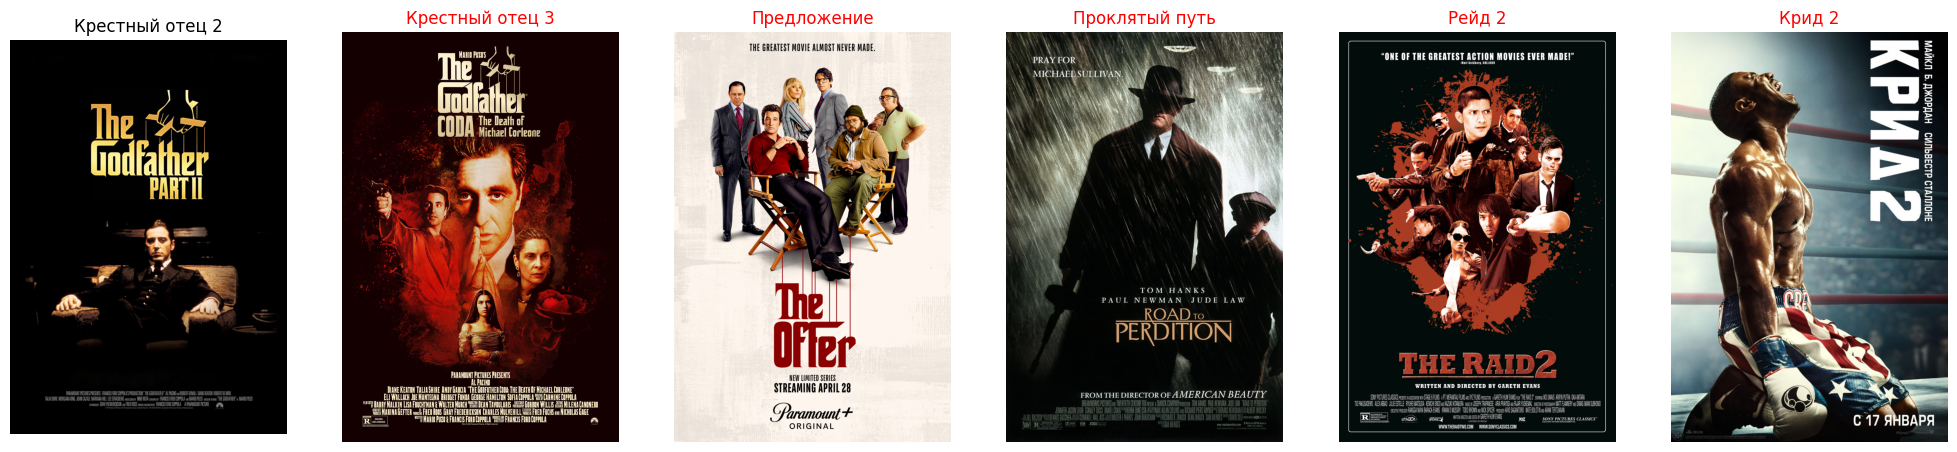

In [78]:
reload(ir)
ir.vis_recs(similarities, movies_df, title_id = 'tt0071562', k=5)

## Prepare submission

In [82]:
reload(ir)
ir.prepare_submission(movies_df, similarities)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 9798/9798 [00:08<00:00, 1189.85it/s]


HITRATE@10 = 0.187
